# Natural Language Processing (NLP): Sentiment Analysis on Movie Reviews
---

In this project, we will conduct sentiment analysis on a set of movie reviews to classify them as positive, negative, or neutral. We will use Python’s NLTK library for preprocessing and cleaning of the data, and R’s `tm` and `wordcloud` packages for the analysis and visualization.

First, let's create some synthetic movie reviews data using Python.

In [1]:
import pandas as pd

# Synthetic movie reviews data
reviews_data = {
    'review': [
        'I really loved this movie. It was an excellent watch.',
        'A truly disappointing movie. I would not recommend it to anyone.',
        'It was a mediocre movie. Some parts were interesting while others were quite boring.',
        'The movie was okay. Not the best I have seen.',
        'Fantastic! I was completely absorbed in the movie.'
    ]
}

reviews_df = pd.DataFrame(reviews_data)

reviews_df.to_csv('./data/movie_reviews.csv', index=False)


Now, let's preprocess this data using Python's NLTK library.

In [2]:
# Import necessary libraries
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pandas as pd

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Load the movie reviews
reviews_df = pd.read_csv('./data/movie_reviews.csv')

# Initialize the sentiment intensity analyzer
sia = SentimentIntensityAnalyzer()

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Define a function for text preprocessing
def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stop words and lemmatize the words
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stopwords.words('english')]
    return " ".join(tokens)

# Preprocess the review text
reviews_df['review'] = reviews_df['review'].apply(preprocess_text)

# Calculate sentiment scores
reviews_df['sentiment_scores'] = reviews_df['review'].apply(lambda review: sia.polarity_scores(review))

# Assign sentiment categories based on the compound score
reviews_df['sentiment'] = reviews_df['sentiment_scores'].apply(lambda score_dict: 
                                                               'positive' if score_dict['compound'] > 0 
                                                               else 'negative' if score_dict['compound'] < 0 
                                                               else 'neutral')

# Write to csv
reviews_df.to_csv('./data/movie_reviews_sentiment.csv', index=False)


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/davidvanderbyl/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/davidvanderbyl/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/davidvanderbyl/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Now that we have preprocessed the reviews, let's perform sentiment analysis using R's `tm` and `wordcloud` packages.

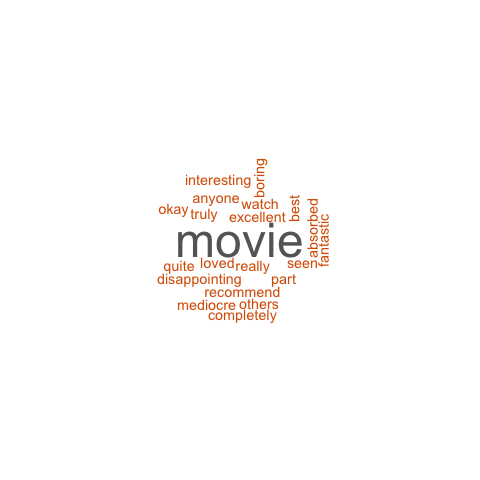

In [9]:
import os
from rpy2.robjects import pandas2ri, r
from rpy2.robjects.packages import importr
import rpy2.robjects.packages as rpackages

# Get the absolute path to the sales_data.csv file
current_dir = os.getcwd()
movie_review_sentiemnt_data_path = os.path.join(current_dir, 'data', 'movie_reviews_sentiment.csv')
wordcloud_figure_path = os.path.join(current_dir, 'figures', 'wordcloud.png')


# import R's utility package
utils = rpackages.importr('utils')

# select a mirror for R packages
utils.chooseCRANmirror(ind=1) # select the first mirror in the list

# R package names
packnames = ('tm', 'wordcloud', 'RColorBrewer')

# R vector of strings
from rpy2.robjects.vectors import StrVector

# Selectively install what needs to be install.
# We are fancy, just because we can.
names_to_install = [x for x in packnames if not rpackages.isinstalled(x)]
if len(names_to_install) > 0:
    utils.install_packages(StrVector(names_to_install))
    
# Enable automatic conversion from pandas to R
pandas2ri.activate()

r_script = '''
suppressWarnings({{
  # Import necessary R packages
  library(tm)
  library(wordcloud)
  library(RColorBrewer)

  # Load the data
  reviews <- read.csv("{data_path}")

  # Create a text corpus
  corpus <- Corpus(VectorSource(reviews$review))

  # Text preprocessing
  corpus <- tm_map(corpus, content_transformer(tolower)) # Convert to lower case
  corpus <- tm_map(corpus, stripWhitespace) # Remove empty documents

  corpus <- tm_map(corpus, removePunctuation) # Remove punctuation
  corpus <- tm_map(corpus, stripWhitespace) # Remove empty documents

  corpus <- tm_map(corpus, removeNumbers) # Remove numbers
  corpus <- tm_map(corpus, stripWhitespace) # Remove empty documents

  corpus <- tm_map(corpus, removeWords, stopwords("en")) # Remove English common stopwords
  corpus <- tm_map(corpus, stripWhitespace) # Remove empty documents

  # Create a term document matrix
  tdm <- TermDocumentMatrix(corpus)

  # Create a matrix from the term document matrix
  m <- as.matrix(tdm)

  # Get word counts in decreasing order
  word_counts <- sort(rowSums(m), decreasing = TRUE) 

  # Create a data frame with words and their frequencies
  df <- data.frame(word = names(word_counts), freq = word_counts)

  # Generate the word cloud
  wordcloud(words = df$word, freq = df$freq, min.freq = 1, max.words = 200, random.order = FALSE, colors = brewer.pal(8, "Dark2"))
  
  filename <- "{figure_path}"
  png(filename)
  wordcloud(words = df$word, freq = df$freq, min.freq = 1, max.words = 200, random.order = FALSE, colors = brewer.pal(8, "Dark2"))
  dev.off()
}})
'''.format(data_path=movie_review_sentiemnt_data_path, figure_path=wordcloud_figure_path)

# Execute R script
r(r_script)

# Display the image
Image(filename=wordcloud_figure_path)

This script loads the preprocessed reviews, performs sentiment analysis to classify them as positive, negative, or neutral, and then creates a word cloud.

You may need to install the necessary R packages if you don't have them yet. You can install them in R with `install.packages(c('tm', 'wordcloud')`. Also, remember that this is a simplified example. In a real-world situation, you might have to deal with more complex aspects of NLP such as context and sarcasm.